# Forecast

- load trained model
- compute ensemble
- export in submission format

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


### Configuration

In [3]:
NUM_SAMPLES = 1000
HORIZON = 4

# Load data

In [4]:
current_date = pd.Timestamp.now().date()
current_date

datetime.date(2024, 10, 8)

In [5]:
forecast_date = get_preceding_thursday(current_date)
forecast_date = str(forecast_date.date())
forecast_date

'2024-10-03'

In [6]:
forecast_date = '2024-05-23'

In [9]:
forecast_date = '2024-01-18'

In [10]:
forecast_date = '2023-11-23'

In [11]:
forecast_date = '2023-11-30'

In [12]:
forecast_date = '2023-12-07'

In [7]:
ts_are = load_target_series('are', forecast_date)
ts_sari = load_target_series('sari', forecast_date)

In [8]:
target_series, covariates = retain_period_common_to_all([ts_sari, ts_are])

<Axes: xlabel='date'>

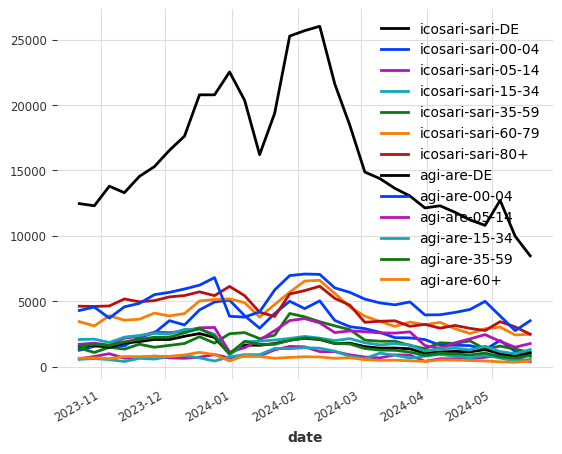

In [9]:
target_series.plot()
covariates.plot()

### One forecast

In [31]:
ts_nowcast = load_nowcast(forecast_date, probabilistic=True, local=True)

<Axes: xlabel='date'>

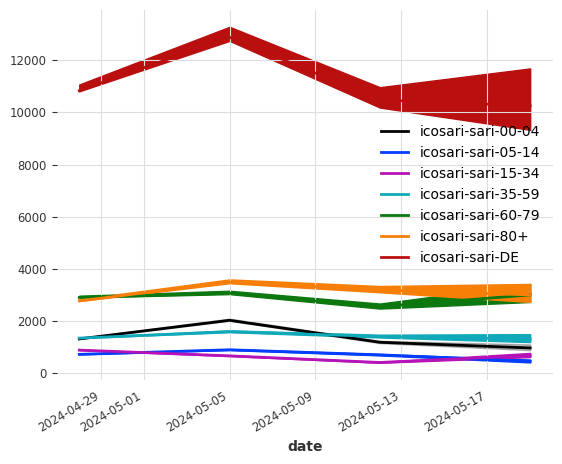

In [32]:
ts_nowcast.plot()

<Axes: xlabel='date'>

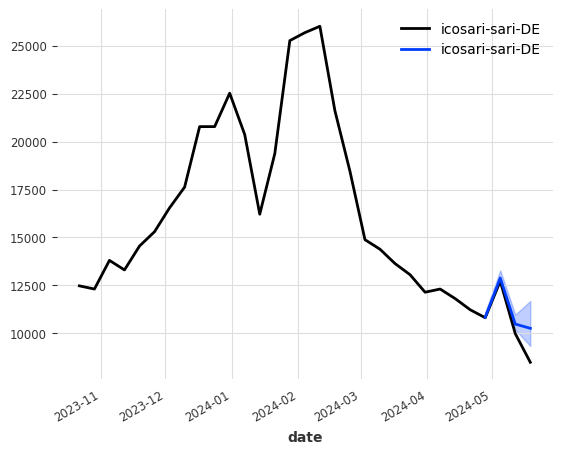

In [34]:
target_series['icosari-sari-DE'].plot()
ts_nowcast['icosari-sari-DE'].plot()

<Axes: xlabel='date'>

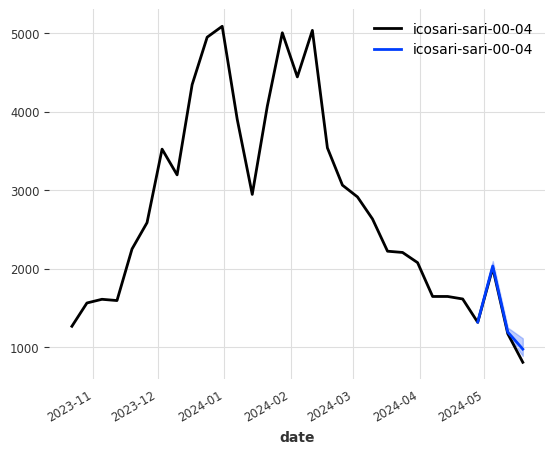

In [35]:
target_series['icosari-sari-00-04'].plot()
ts_nowcast['icosari-sari-00-04'].plot()

In [36]:
ts_nowcast.columns

Index(['icosari-sari-00-04', 'icosari-sari-05-14', 'icosari-sari-15-34',
       'icosari-sari-35-59', 'icosari-sari-60-79', 'icosari-sari-80+',
       'icosari-sari-DE'],
      dtype='object', name='component')

In [38]:
filepath = f'../data/nowcasts/KIT-baseline/{forecast_date}-icosari-sari-KIT-baseline.csv'
df = pd.read_csv(filepath)
df = df[(df.type == 'quantile') & (df.horizon >= -3)]
df = df.rename(columns={'target_end_date' : 'date'})

In [43]:
df.sort_values(['location', 'age_group'], ignore_index=True)

,location,age_group,forecast_date,date,horizon,type,quantile,value
0,DE,00+,2024-05-23,2024-05-19,0,quantile,0.05,9169
1,DE,00+,2024-05-23,2024-05-19,0,quantile,0.10,9350
2,DE,00+,2024-05-23,2024-05-19,0,quantile,0.15,9489
3,DE,00+,2024-05-23,2024-05-19,0,quantile,0.20,9611
4,DE,00+,2024-05-23,2024-05-19,0,quantile,0.25,9723
...,...,...,...,...,...,...,...,...
527,DE,80+,2024-05-23,2024-04-28,-3,quantile,0.75,2797
528,DE,80+,2024-05-23,2024-04-28,-3,quantile,0.80,2805
529,DE,80+,2024-05-23,2024-04-28,-3,quantile,0.85,2817
530,DE,80+,2024-05-23,2024-04-28,-3,quantile,0.90,2835


In [ ]:
all_nowcasts = []
for age in df.age_group.unique():
    # print(age)
    df_temp = df[df.age_group == age]

    # transform nowcast into a TimeSeries object
    nowcast_age = TimeSeries.from_group_dataframe(df_temp, group_cols=['age_group', 'quantile'],
                          time_col='date', value_cols='value', 
                          freq='7D', fillna_value=0)

    nowcast_age = concatenate(nowcast_age, axis='sample')
    nowcast_age.static_covariates.drop(columns=['quantile'], inplace=True, errors='ignore')
    nowcast_age = nowcast_age.with_columns_renamed(nowcast_age.components, ['icosari-sari-' + age])

    all_nowcasts.append(nowcast_age)

all_nowcasts = concatenate(all_nowcasts, axis='component')
all_nowcasts = all_nowcasts.with_columns_renamed('icosari-sari-00+', 'icosari-sari-DE')

In [14]:
target_list = make_target_paths(target_series, ts_nowcast)

In [17]:
target_list = [encode_static_covariates(t, ordinal=False) for t in target_list]

In [18]:
covariates = [covariates]*len(target_list) if covariates else None

In [21]:
name = 'tsmixer'

In [23]:
model_path = f'../models/realtime/realtime_{name}-1.pt'
model = TSMixerModel.load(model_path)

In [24]:
model

TSMixerModel(output_chunk_shift=0, hidden_size=16, ff_size=16, num_blocks=4, activation=ReLU, dropout=0.2, norm_type=TimeBatchNorm2d, normalize_before=False, use_static_covariates=False, n_epochs=500, batch_size=8, optimizer_kwargs={'lr': 0.01, 'weight_decay': 0.0001}, input_chunk_length=8, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, output_chunk_length=4, likelihood=NegativeBinomialLikelihood(), pl_trainer_kwargs={'enable_progress_bar': True, 'enable_model_summary': False, 'accelerator': 'cpu', 'callbacks': [<pytorch_lightning.callbacks.progress.rich_progress.RichProgressBar object at 0x7fa1ea082d30>]}, random_state=1)

In [25]:
fct = model.predict(n=4, 
                    series=target_list, 
                    past_covariates=covariates, 
                    num_samples=1000)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 0:00:05 • 0:00:00 0.66it/s

In [26]:
ts_forecast = concatenate(fct, axis='sample')

In [27]:
hfc_path = f'../data/submissions/{forecast_date}-icosari-sari-DW-{name}.csv'

In [28]:
hfc_path

'../data/submissions/2024-05-23-icosari-sari-DW-tsmixer.csv'

In [29]:
hfc = ts_forecast

In [30]:
df = reshape_hfc([hfc])

In [31]:
df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])

In [32]:
df.to_csv(hfc_path, index=False)

In [33]:
target_sari = load_target_series('sari')

In [44]:
stratum = 'DE'

In [37]:
stratum = '15-34'

In [42]:
stratum = '60-79'

In [41]:
target_sari.columns

Index(['icosari-sari-DE', 'icosari-sari-00-04', 'icosari-sari-05-14',
       'icosari-sari-15-34', 'icosari-sari-35-59', 'icosari-sari-60-79',
       'icosari-sari-80+'],
      dtype='object', name='component')

In [39]:
stratum = '80+'

<Axes: xlabel='date'>

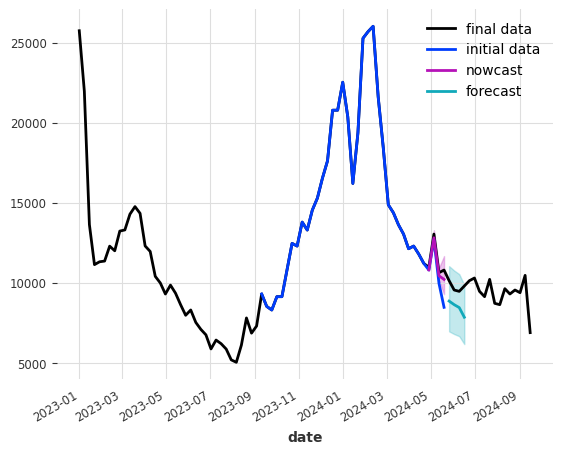

In [45]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
# fct[0][f'icosari-sari-{stratum}'].plot(label='low')
# fct[-1][f'icosari-sari-{stratum}'].plot()
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

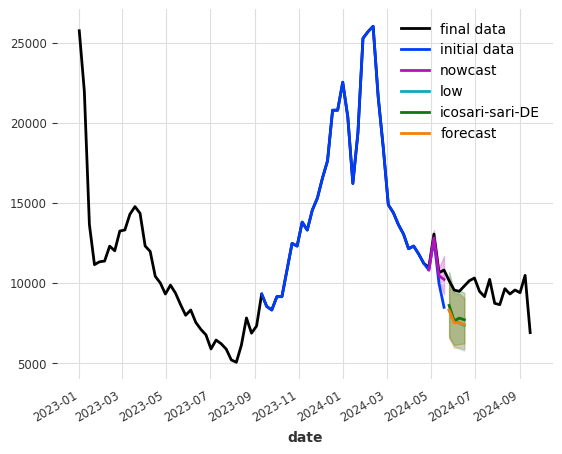

In [396]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
fct[0][f'icosari-sari-{stratum}'].plot(label='low')
fct[-1][f'icosari-sari-{stratum}'].plot()
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

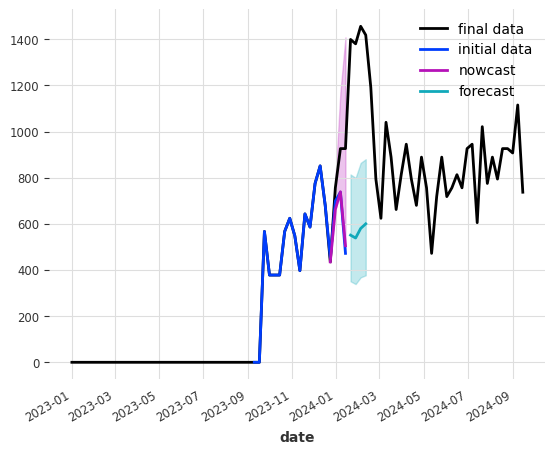

In [355]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

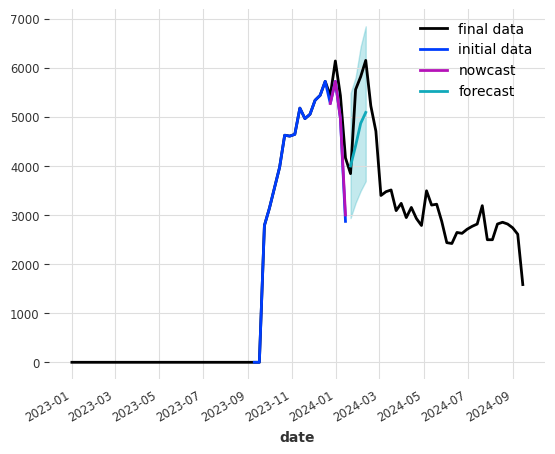

In [327]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

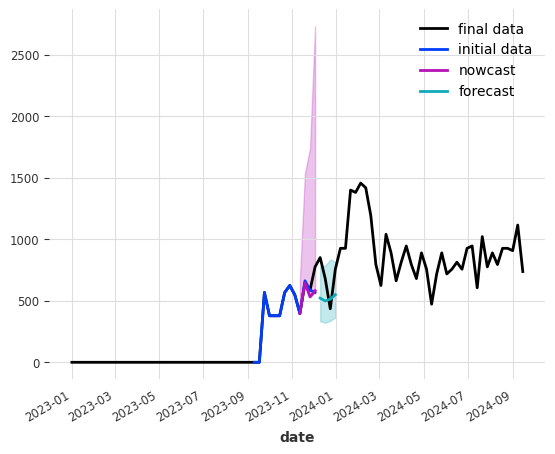

In [297]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

<Axes: xlabel='date'>

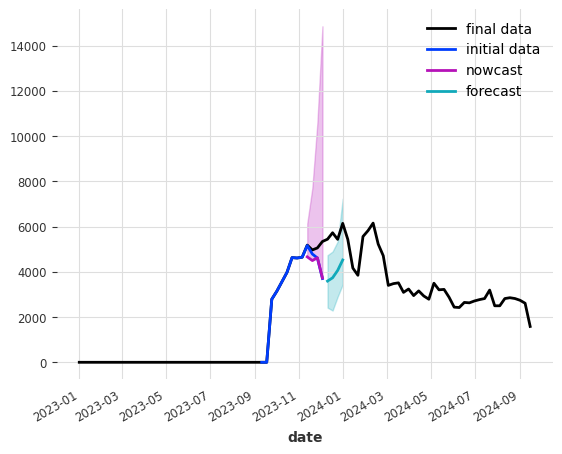

In [231]:
target_sari[f'icosari-sari-{stratum}'].plot(label='final data')
target_series[f'icosari-sari-{stratum}'].plot(label='initial data')
ts_nowcast[f'icosari-sari-{stratum}'].plot(label='nowcast')
hfc[f'icosari-sari-{stratum}'].plot(label='forecast')

In [46]:
target_sari = load_target_series('sari')

In [47]:
df_plot = prepare_plot_data(df, target_sari)

In [110]:
df_plot = prepare_plot_data(df, ts_sari)

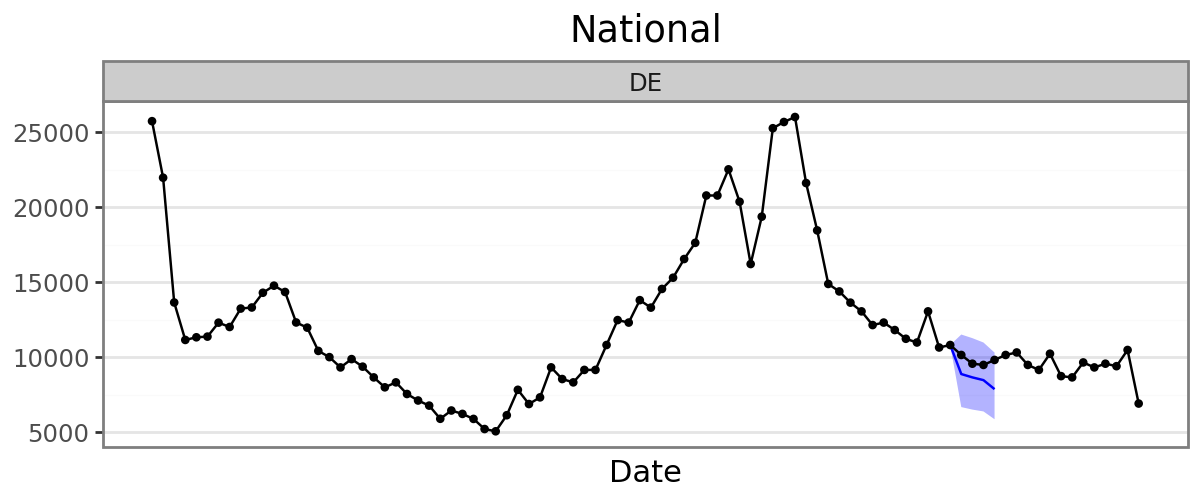

In [48]:
plot_forecasts(df_plot, 'national', start=0)

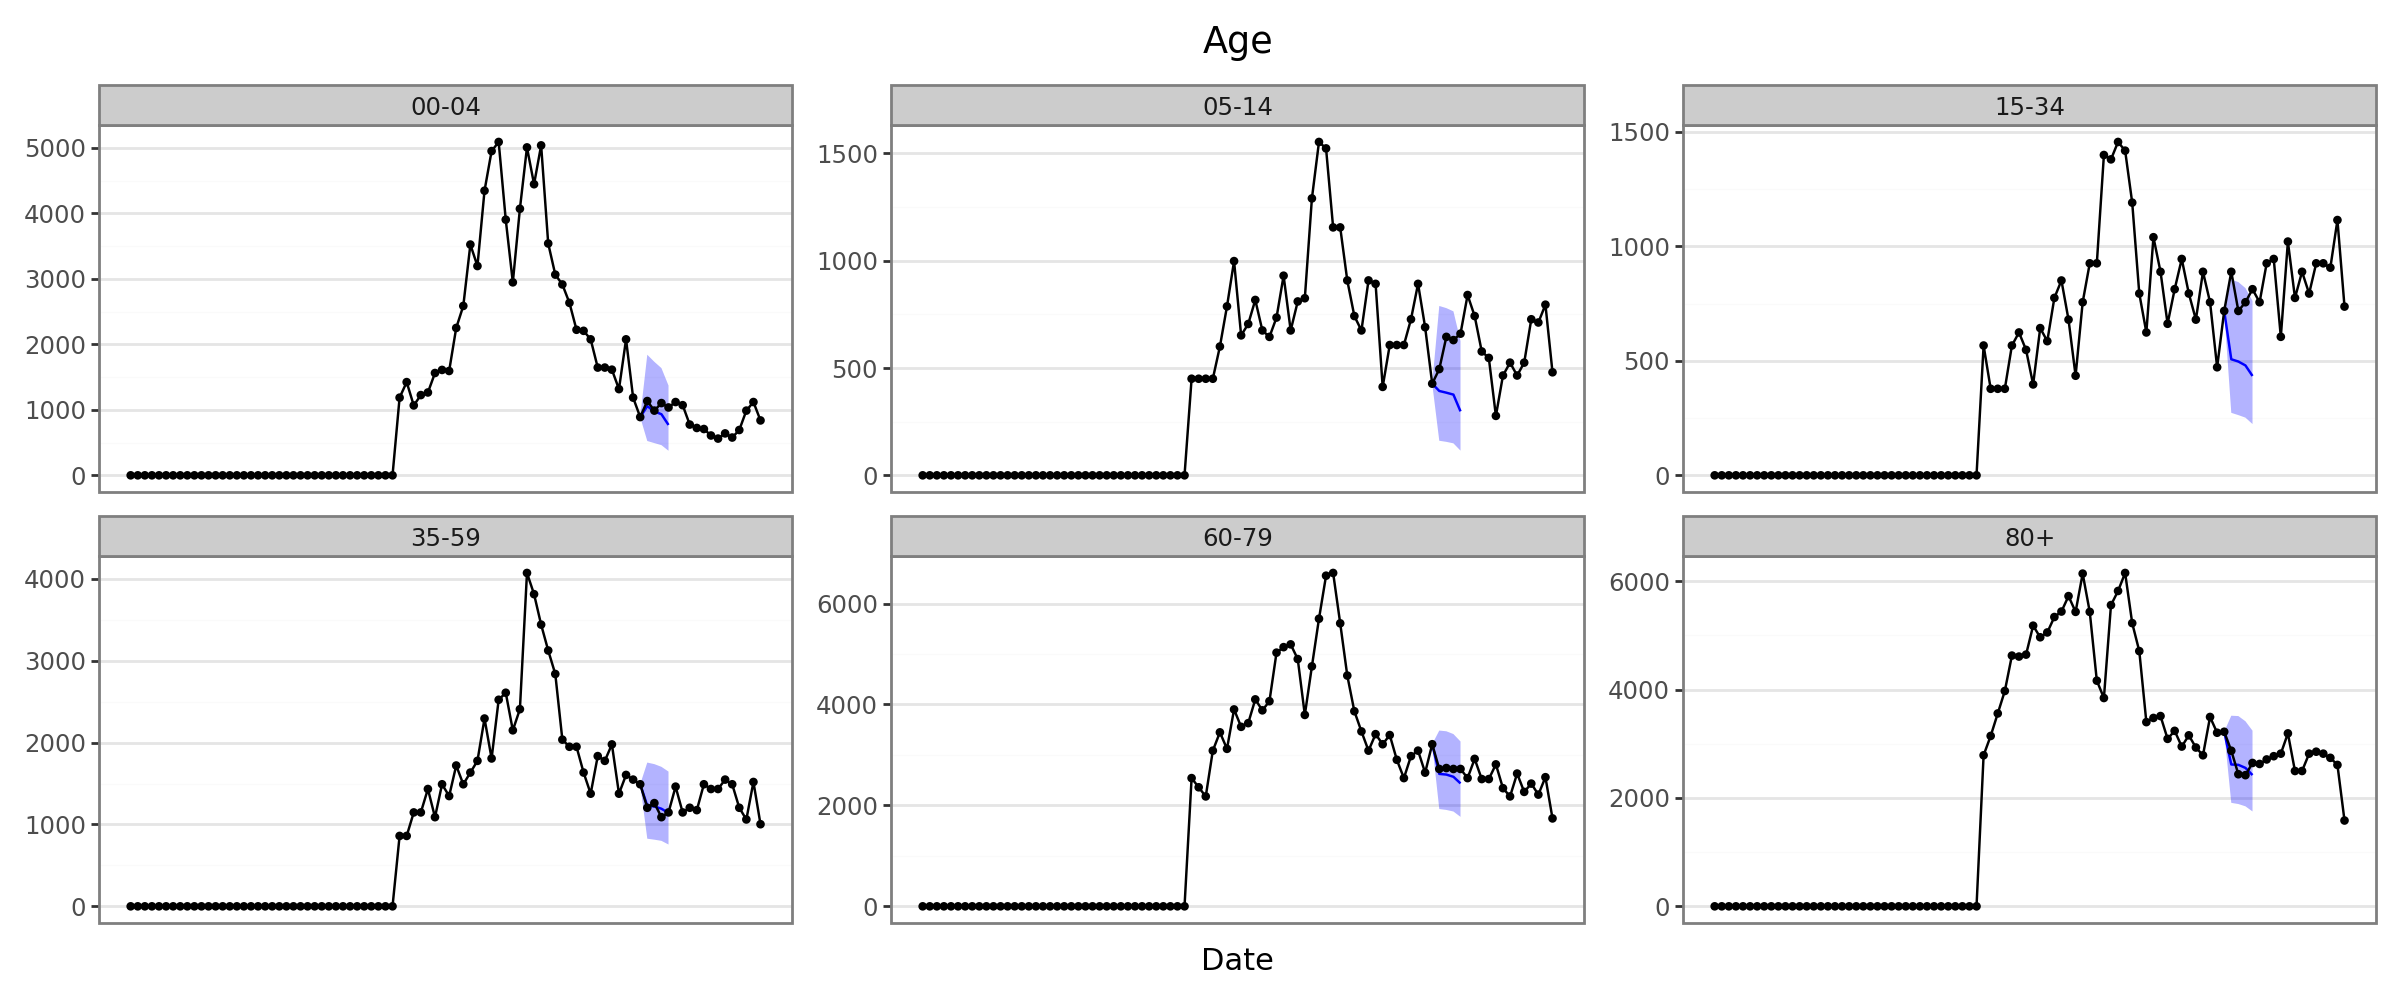

In [49]:
plot_forecasts(df_plot, 'age', start=0)

### Multiple forecasts

In [10]:
# def compute_forecast(model, target_series, covariates, forecast_date, horizon, num_samples, vincentization=True, probabilistic_nowcast=True, local=False):
#     '''
#     For every sample path given by the nowcasted quantiles, a probabilistic forecast is computed.
#     These are then aggregated into one forecast by combining all predicted paths.
#     '''
#     ts_nowcast = load_nowcast(forecast_date, probabilistic_nowcast, local)
#     target_list = make_target_paths(target_series, ts_nowcast)
#     target_list = [encode_static_covariates(t, ordinal=False) for t in target_list]
     
#     covariates = [covariates]*len(target_list) if covariates else None
      
#     fct = model.predict(n=horizon, 
#                         series=target_list, 
#                         past_covariates=covariates, 
#                         num_samples=num_samples)
    
#     if vincentization:
#         df = reshape_hfc(fct)
#         df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()
#     else:
#         ts_forecast = concatenate(fct, axis='sample')
#         df = reshape_forecast(ts_forecast)
        
#     return df

In [11]:
target_series, covariates = retain_period_common_to_all([ts_sari, ts_are])

In [12]:
# hfc = compute_forecast(model, target_series, covariates, forecast_date, HORIZON, NUM_SAMPLES, vincentization=True, probabilistic_nowcast=True, local=True)

In [13]:
RANDOM_SEEDS = [1, 2, 3, 4, 5] # , 6, 7, 8, 9, 10]

In [14]:
name = 'tsmixer'

In [15]:
dfs = []
for seed in RANDOM_SEEDS:
    print(seed)
    model_path = f'../models/realtime/realtime_{name}-{seed}.pt'
    model = TSMixerModel.load(model_path)
    
    df = compute_forecast(model, target_series, covariates, forecast_date, HORIZON, NUM_SAMPLES, vincentization=True, probabilistic_nowcast=False, local=True)
    
    #df = reshape_hfc([hfc])
    dfs.append(df)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


In [16]:
df = pd.concat(dfs)
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

In [17]:
df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])

In [22]:
df.to_csv(f'../data/submissions/{forecast_date}-icosari-sari-DW-{name}3.csv', index=False)

# Plot forecasts

In [18]:
target_sari = load_target_series('sari')

In [19]:
df_plot = prepare_plot_data(df, target_sari)

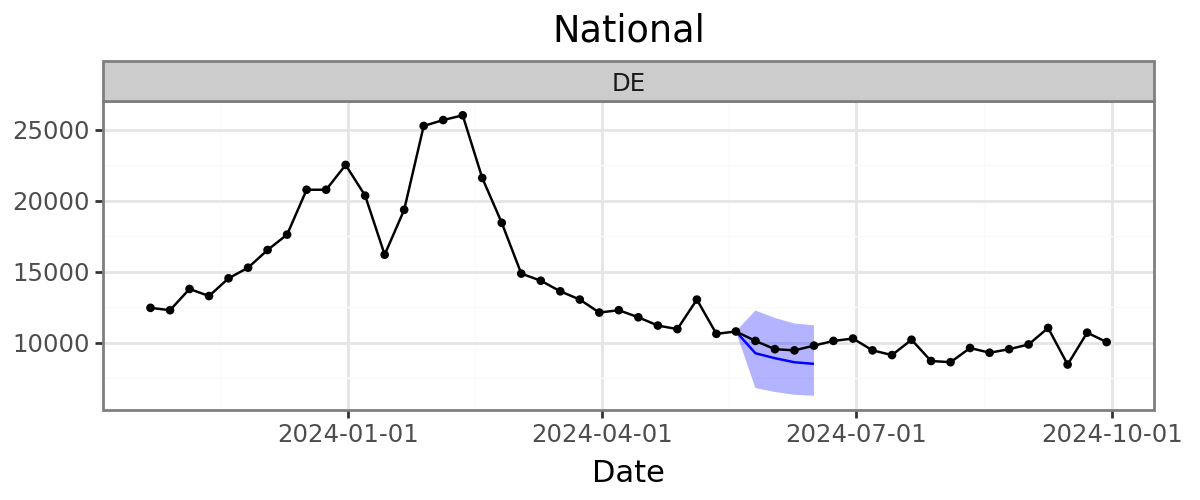

In [20]:
plot_forecasts(df_plot, 'national', start=0)

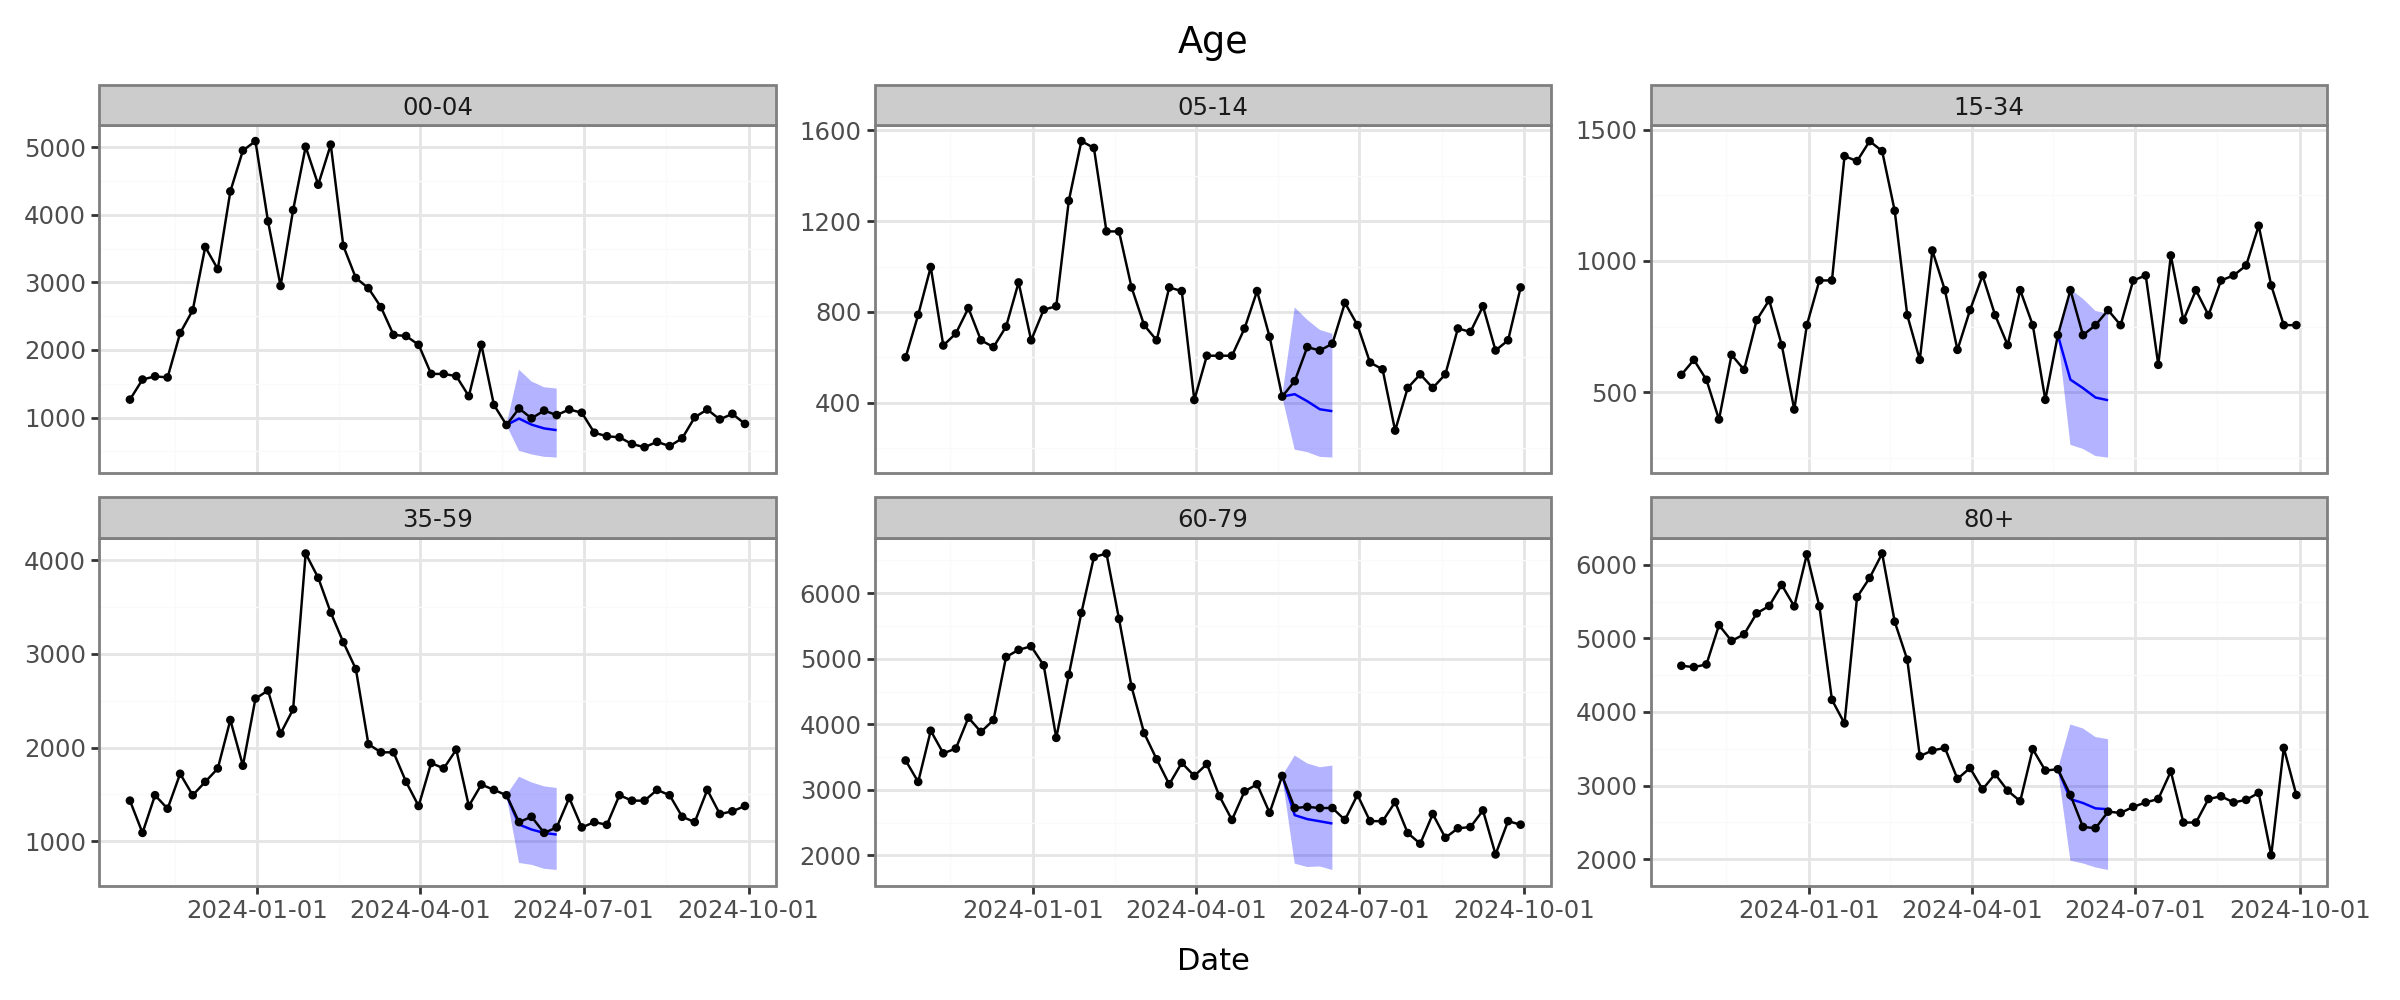

In [21]:
plot_forecasts(df_plot, 'age', start=0)

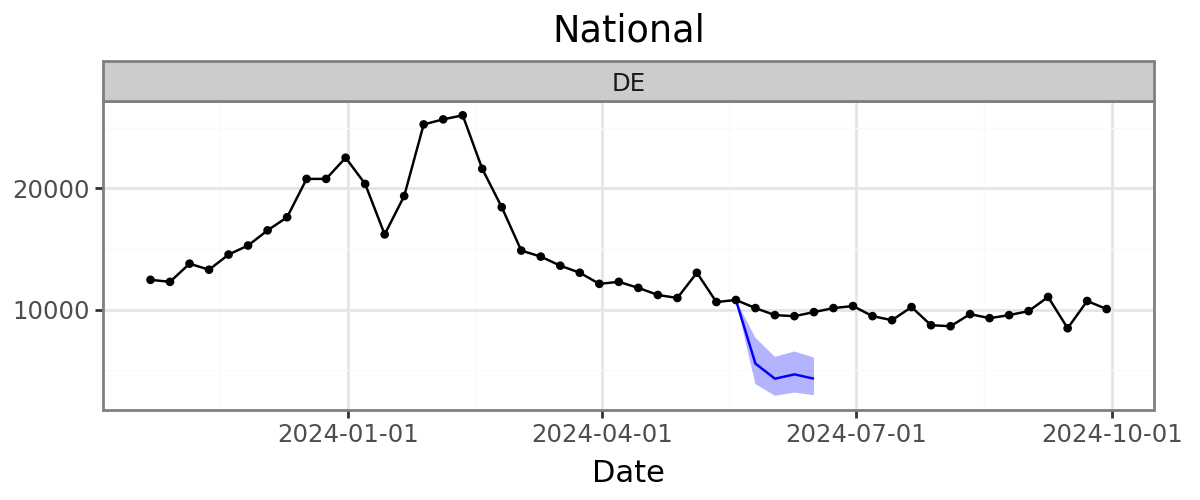

In [23]:
plot_forecasts(df_plot, 'national', start=0)

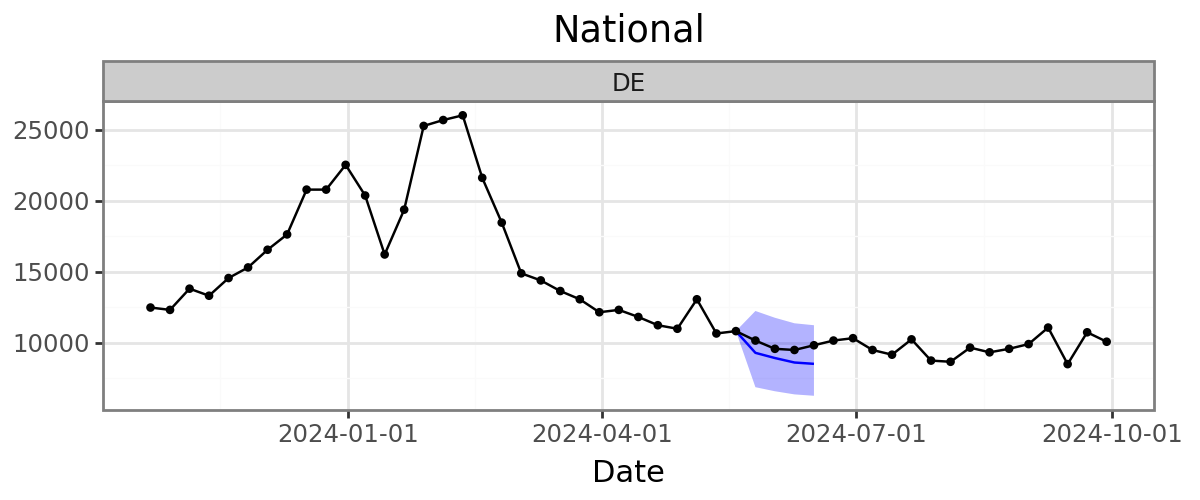

In [26]:
plot_forecasts(df_plot, 'national', start=0)

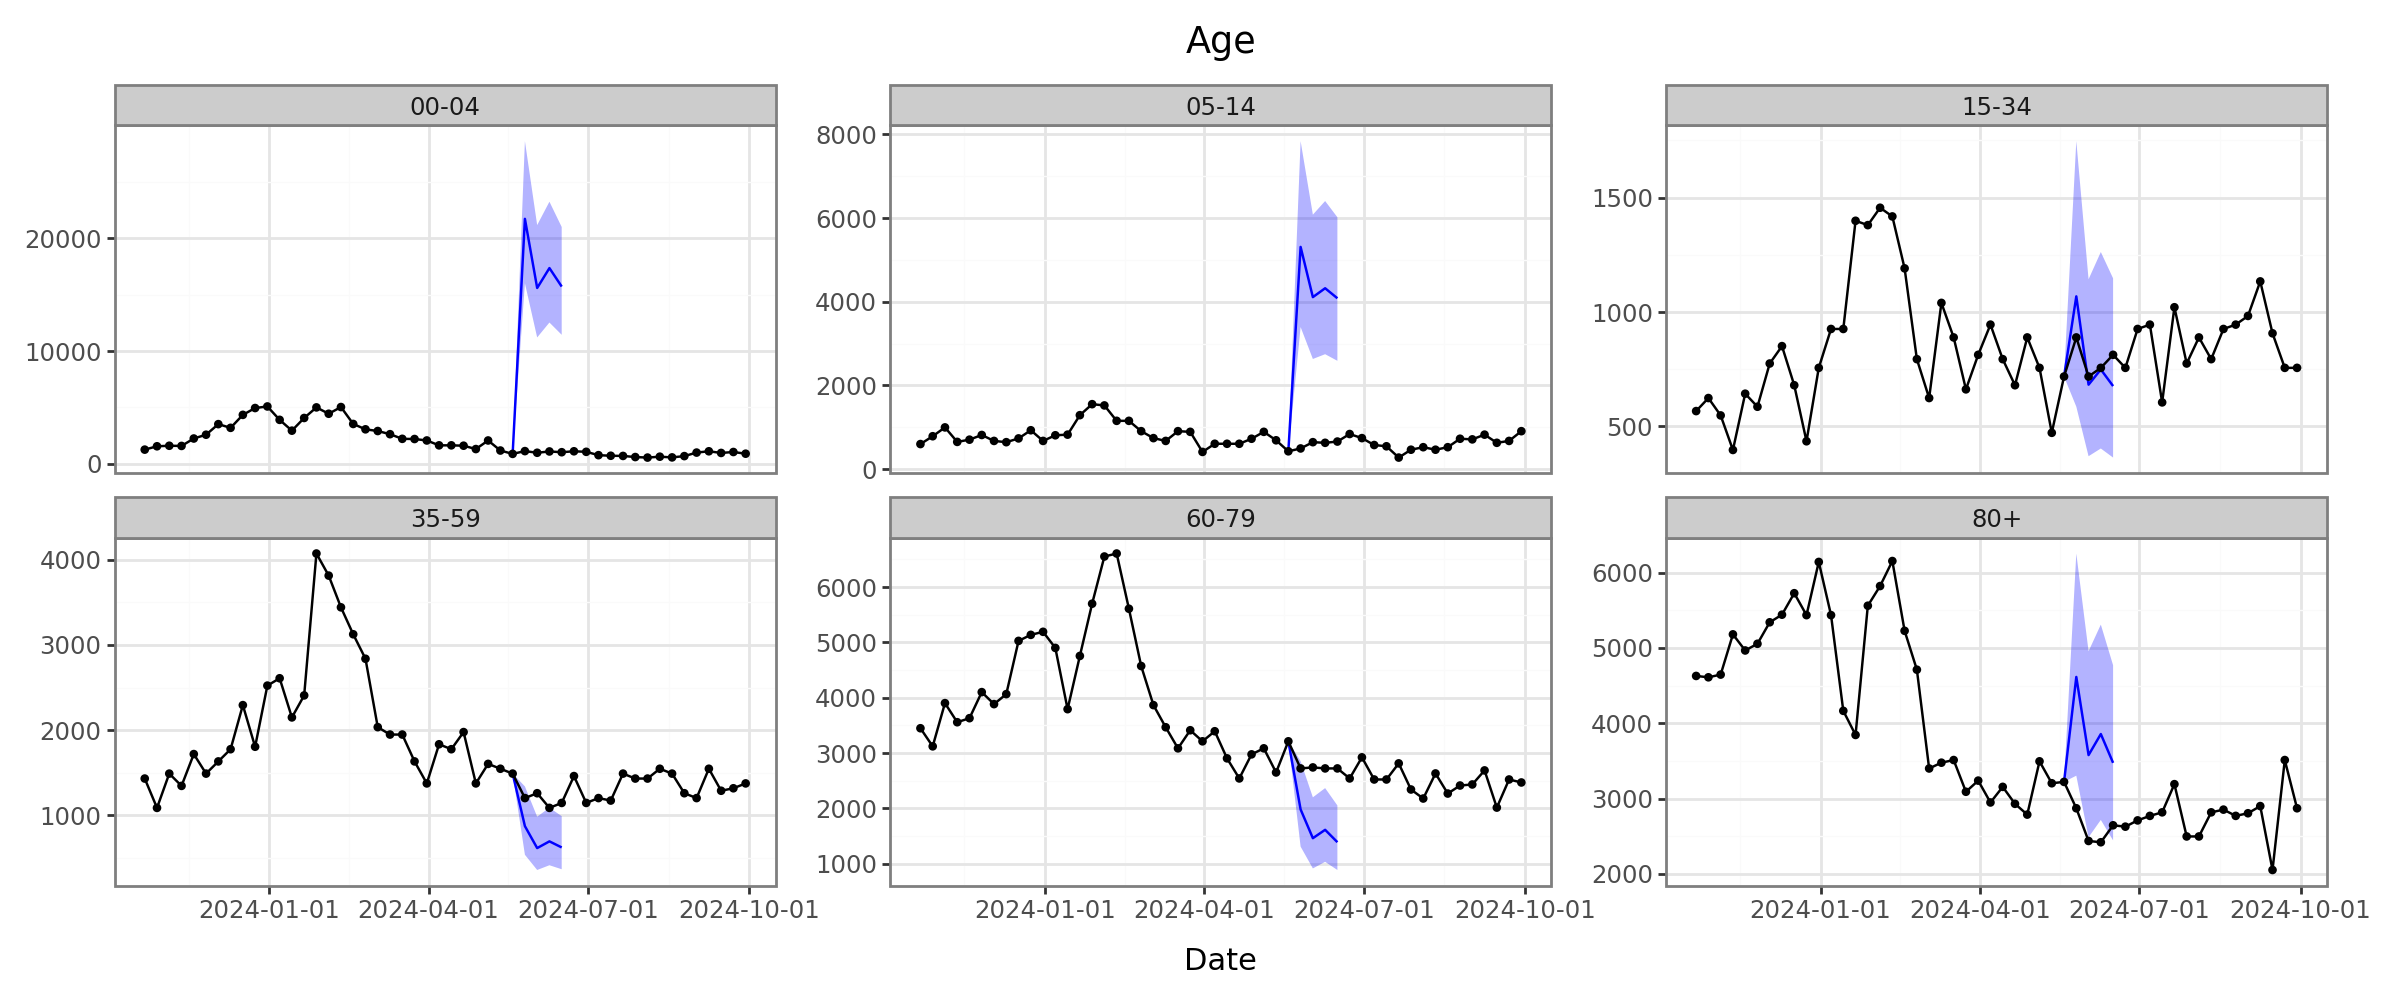

In [39]:
plot_forecasts(df_plot, 'age', start=0)

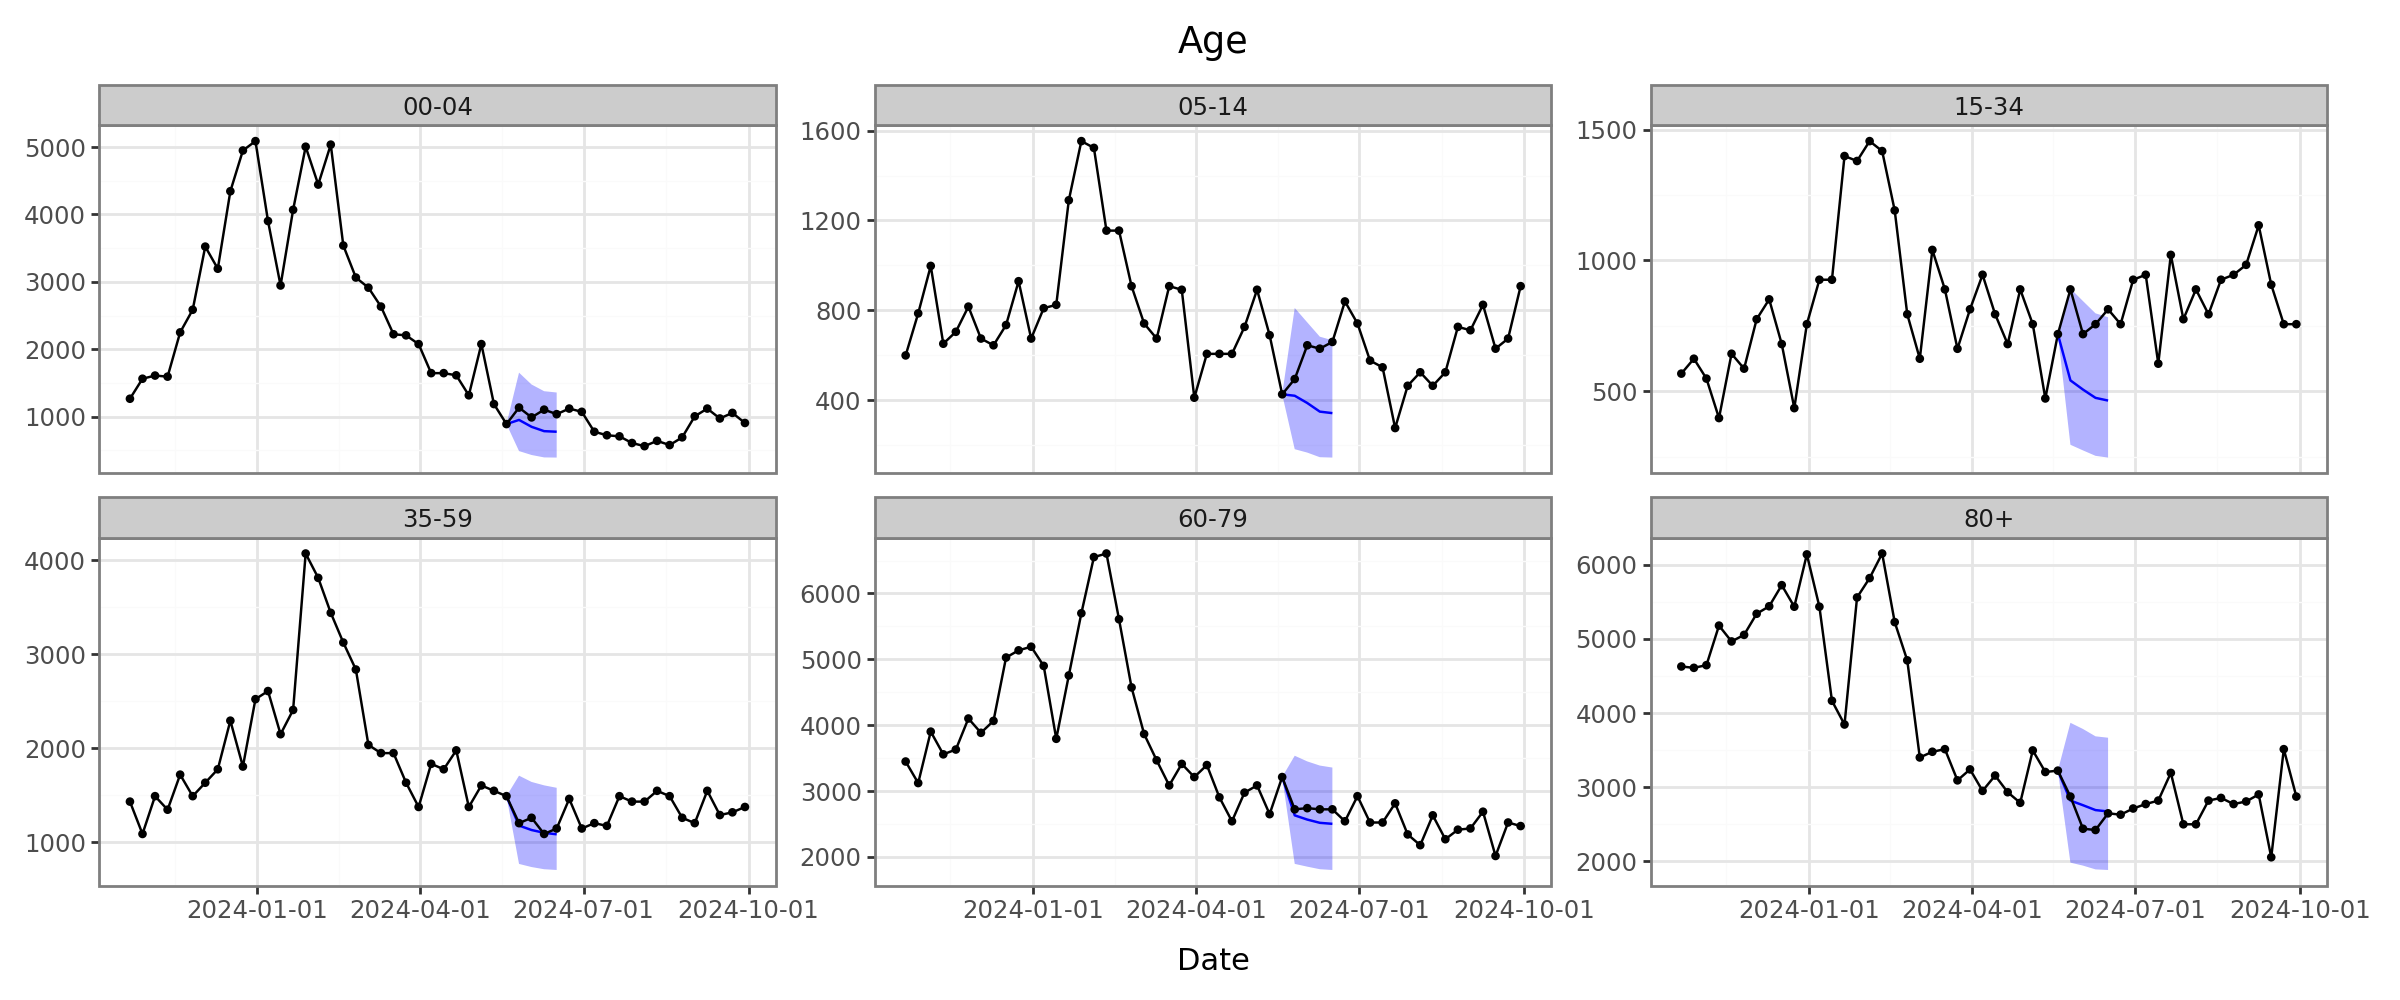

In [27]:
plot_forecasts(df_plot, 'age', start=0)